In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras import backend as K

# Allow graph embeding in notebook
%matplotlib inline

/Users/huiw/.virtualenvs/cv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import load_model
model = load_model('two.model')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 64, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 32, 64)        0         
__________

In [5]:
img_path = 'example.jpg'
# We preprocess the image into a 4D tensor
from keras.preprocessing import image

img = image.load_img(img_path, grayscale=True, target_size=(32, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

print(img_tensor.shape)

(1, 32, 64, 1)


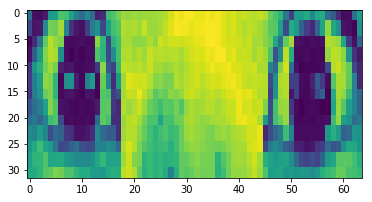

In [6]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0].squeeze())
plt.show()

In [9]:
from keras import models

# Extracts the outputs of the top 21 layers(layers before flatten layer):
layer_outputs = [layer.output for layer in model.layers[:10]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [10]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 32, 64, 64)


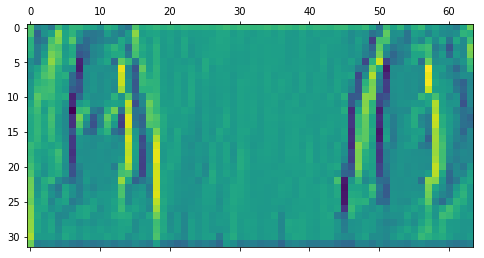

In [12]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

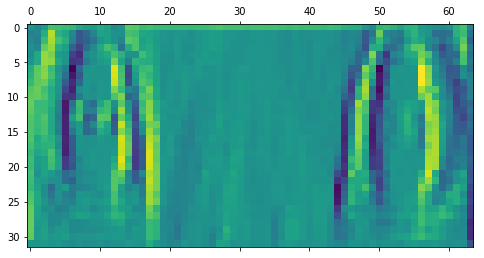

In [13]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

In [14]:
last_layer_activation = activations[-1]
print(last_layer_activation.shape)

(1, 8, 16, 64)


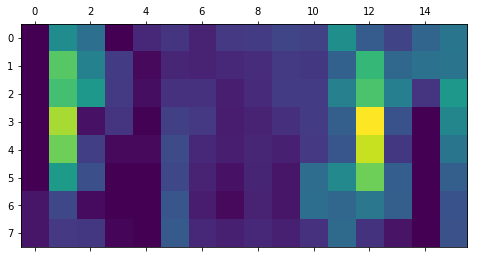

In [15]:
plt.matshow(last_layer_activation[0, :, :, 50], cmap='viridis')
plt.show()

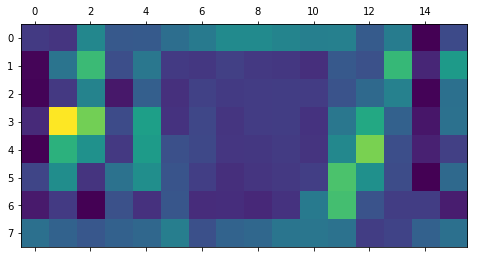

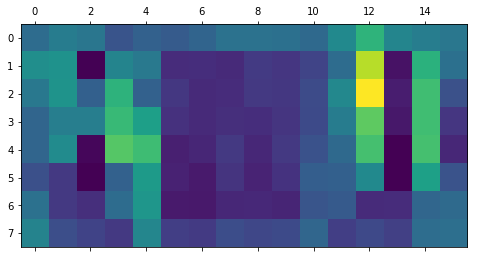

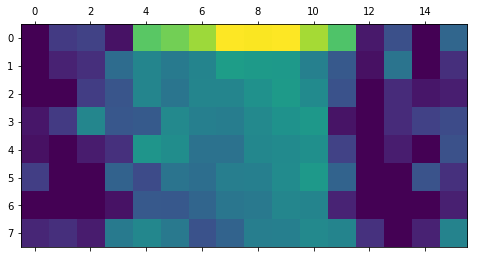

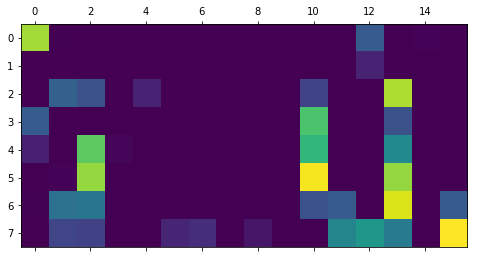

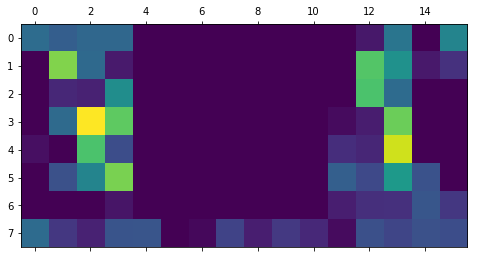

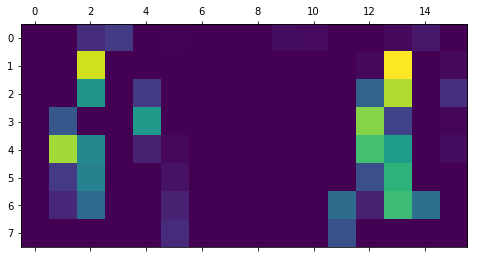

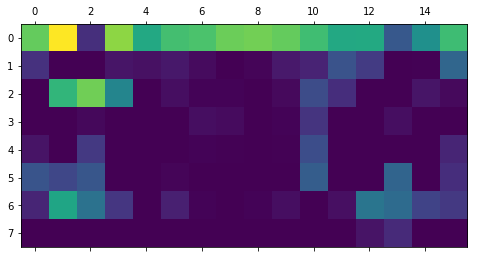

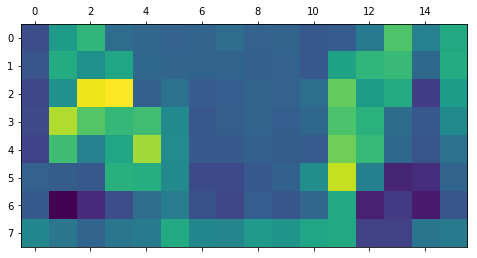

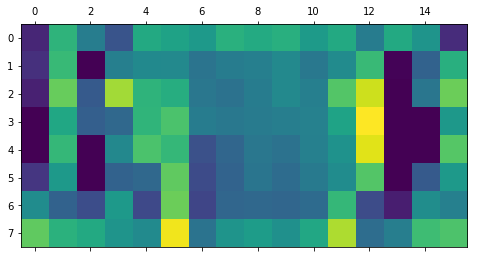

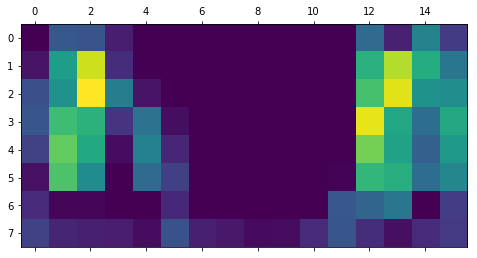

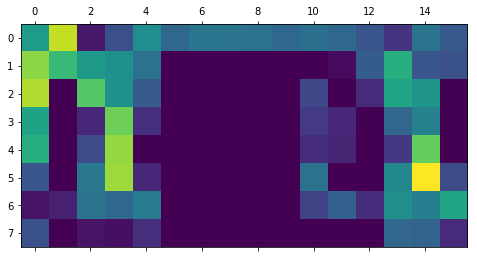

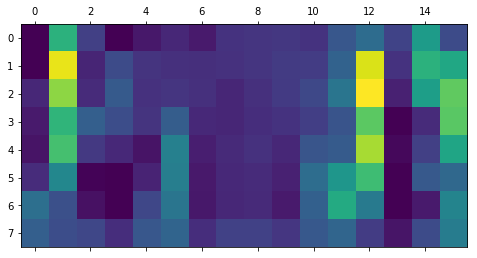

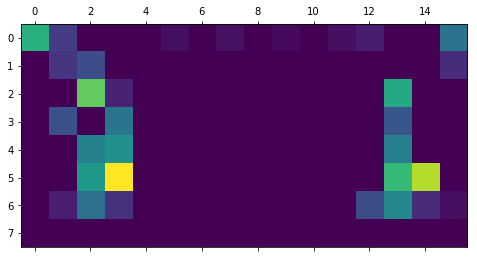

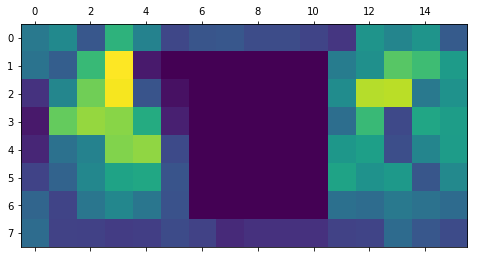

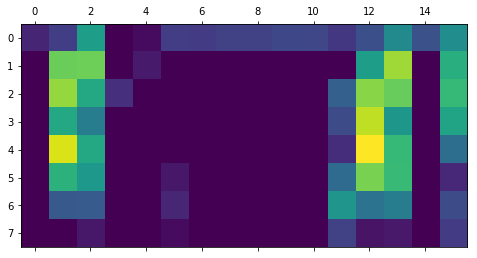

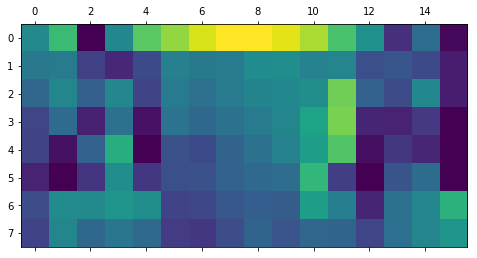

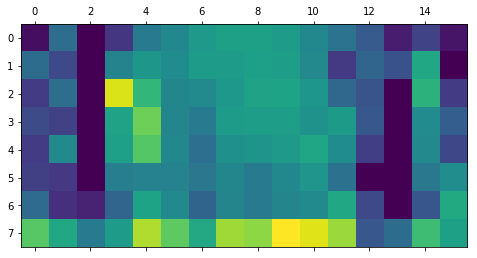

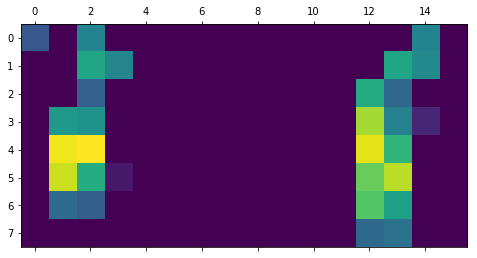

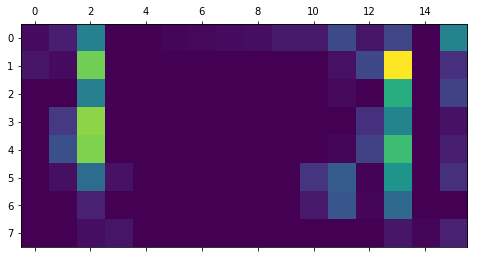

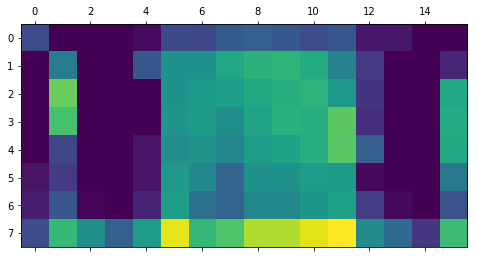

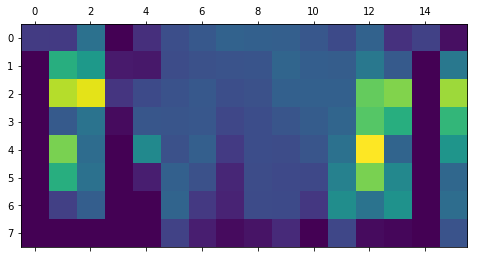

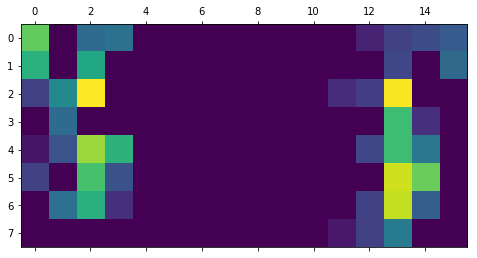

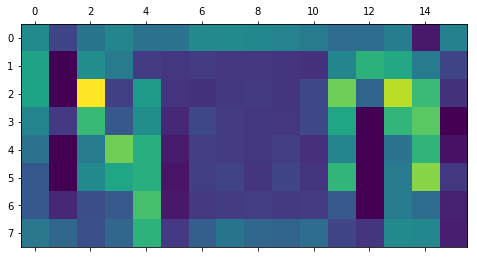

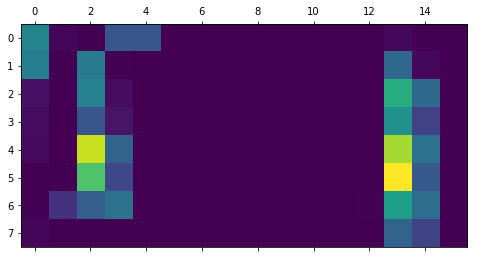

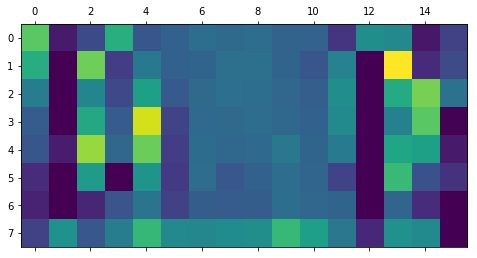

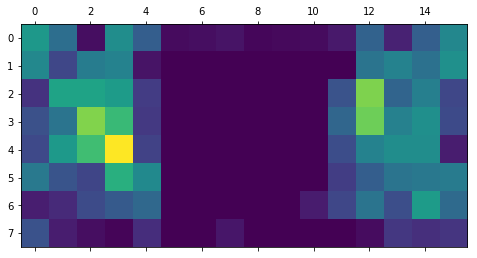

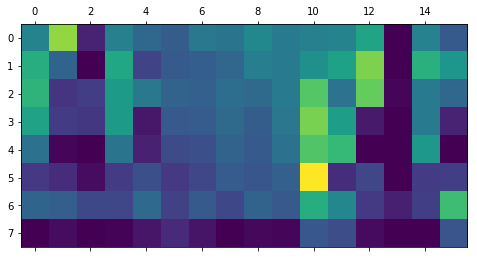

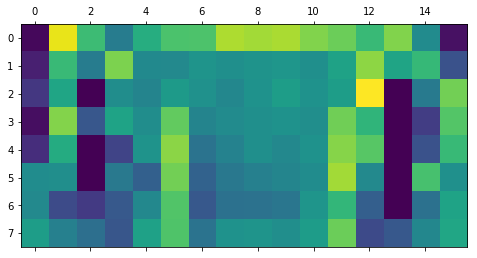

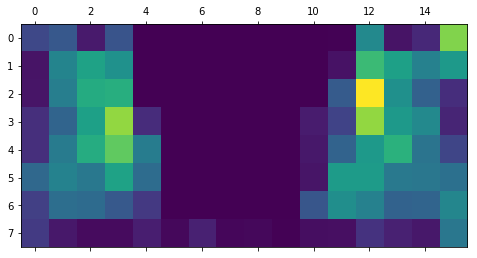

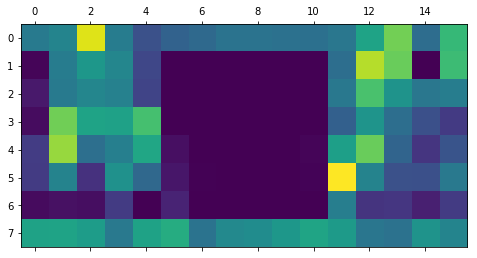

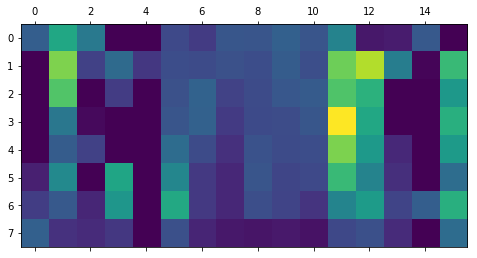

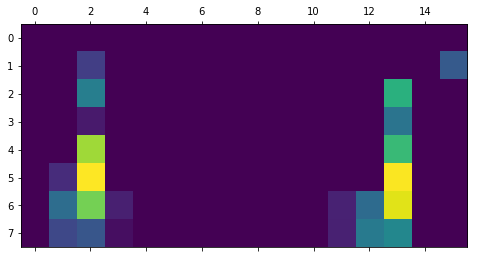

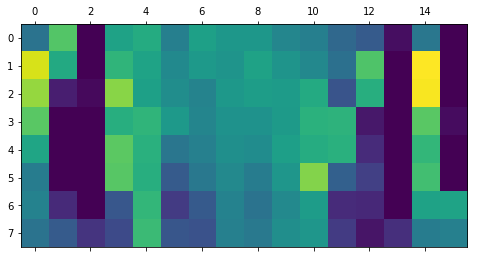

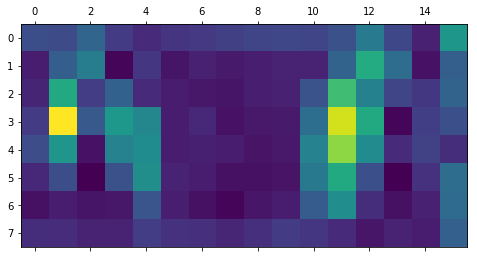

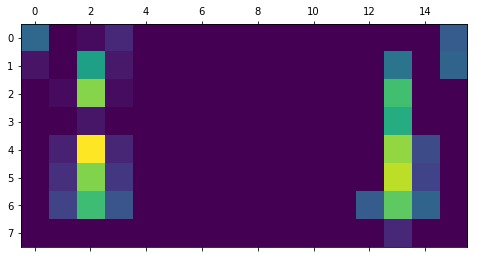

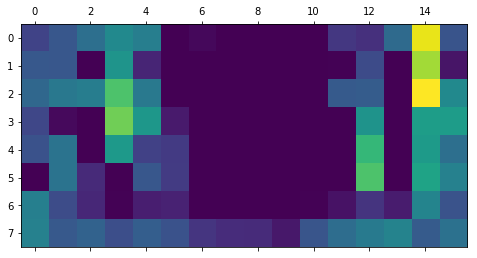

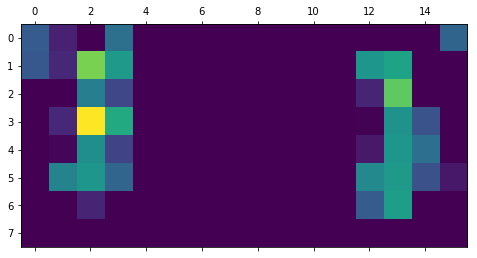

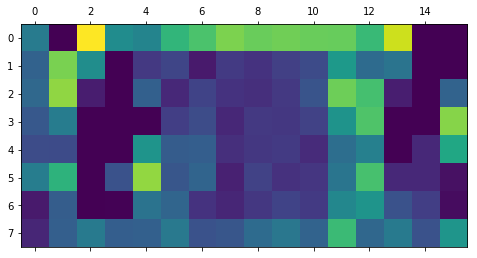

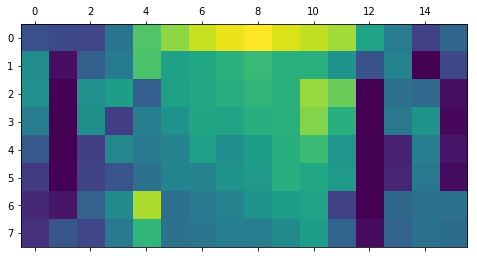

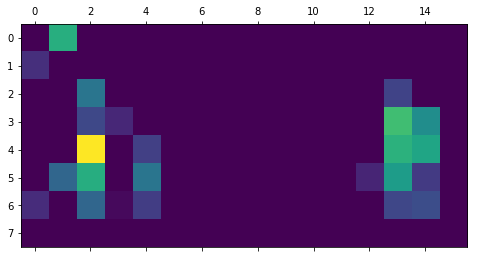

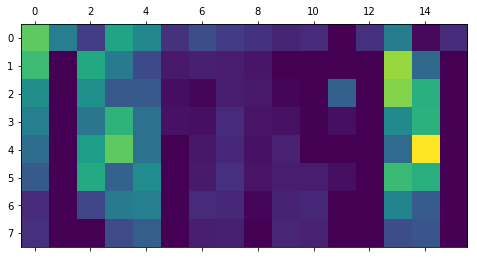

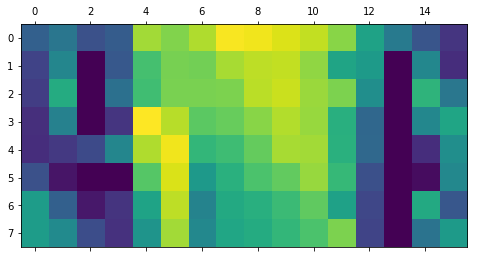

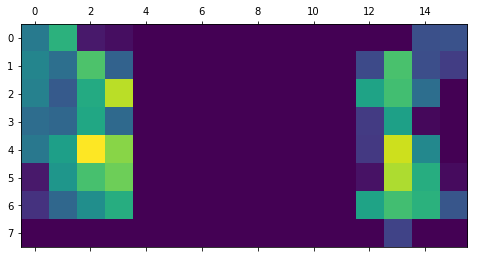

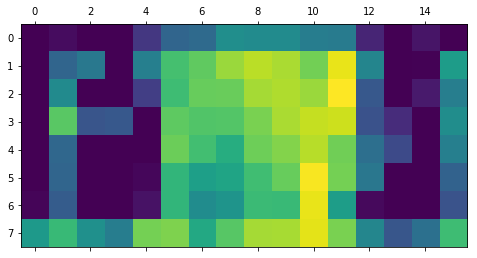

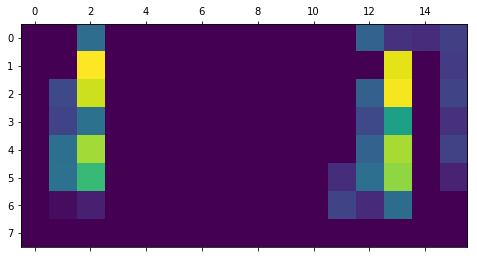

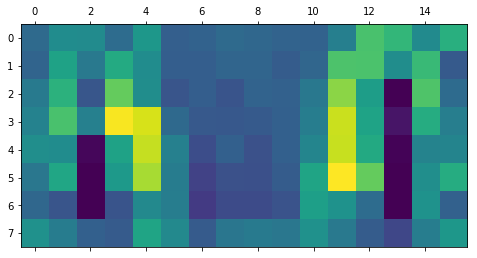

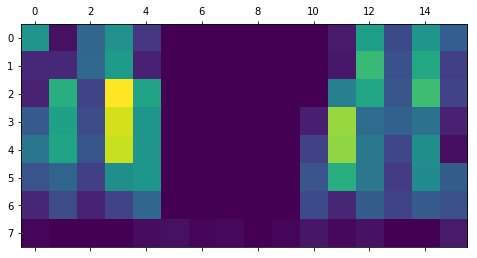

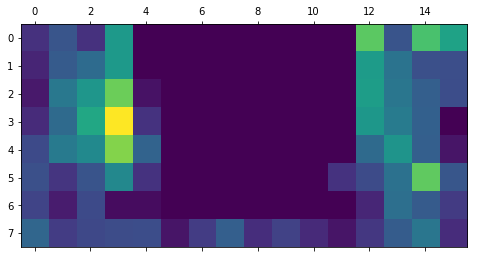

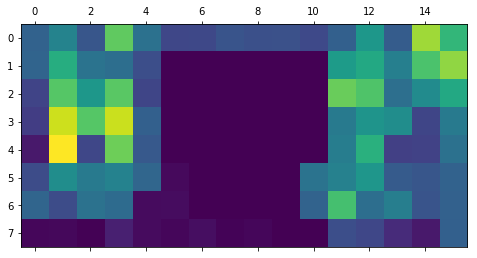

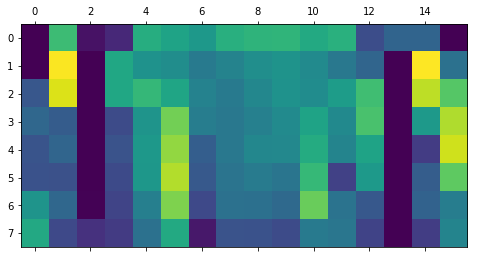

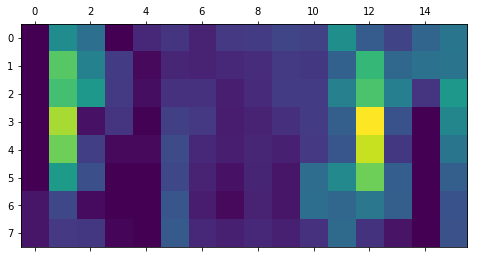

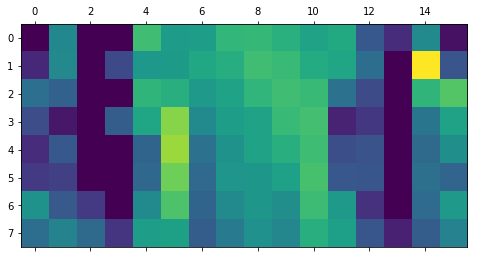

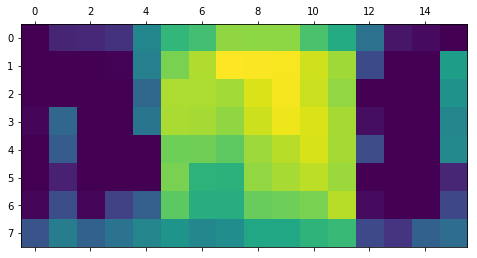

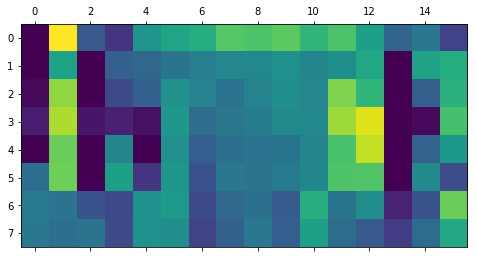

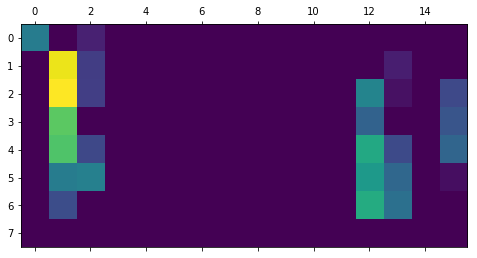

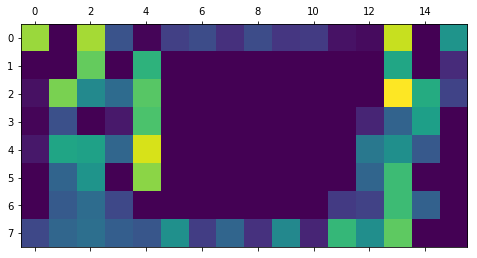

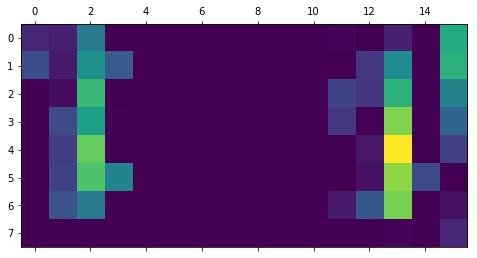

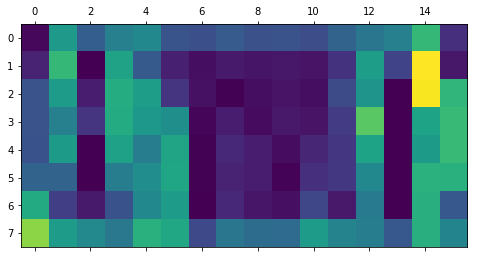

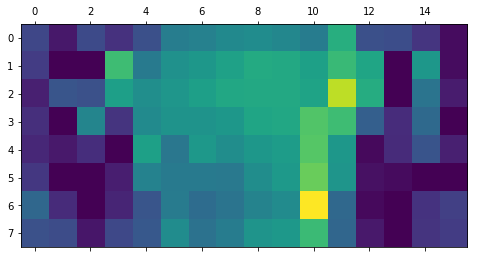

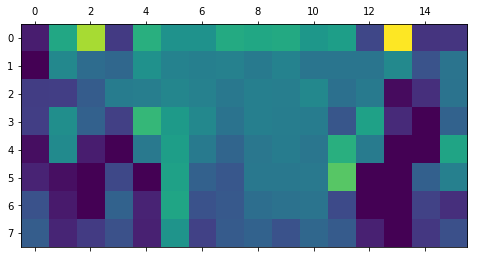

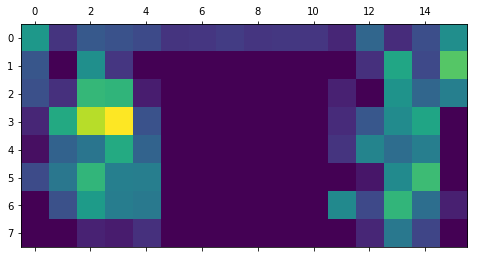

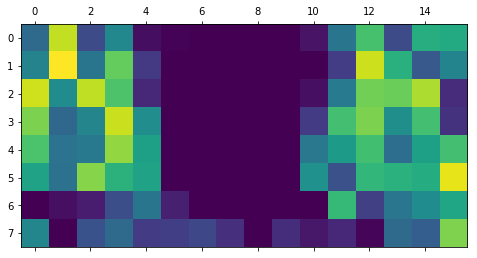

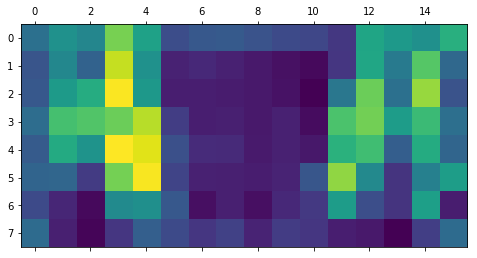

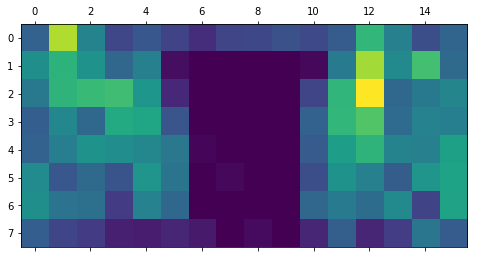

In [16]:
for i in range(64):
    plt.matshow(last_layer_activation[0, :, :, i], cmap='viridis')
    plt.show()

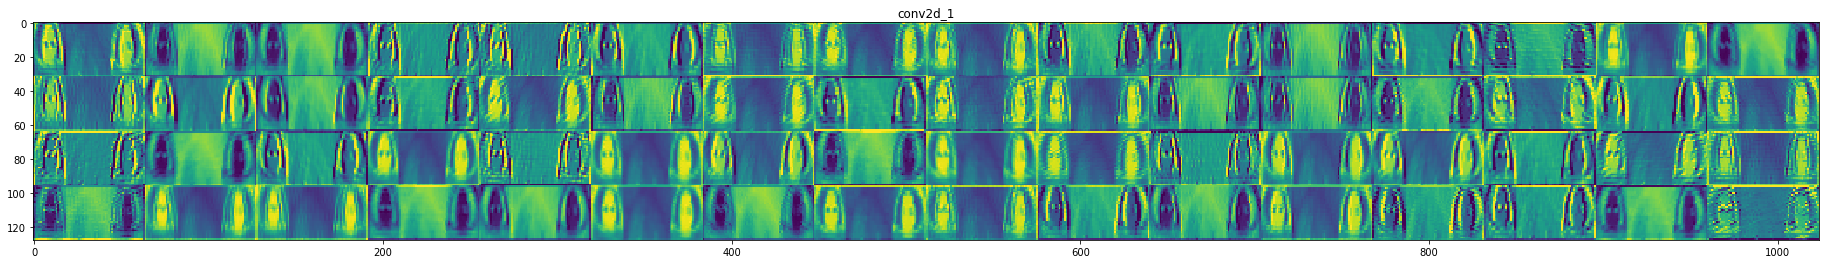

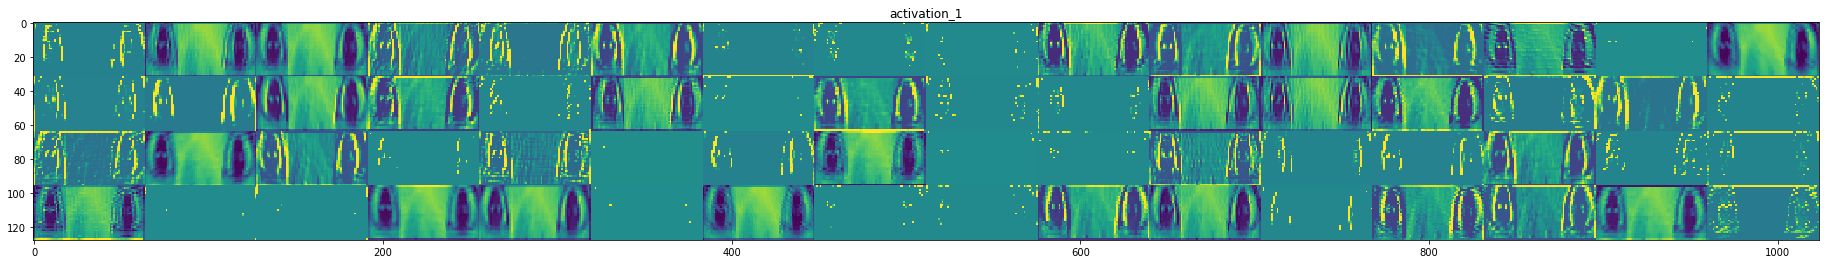

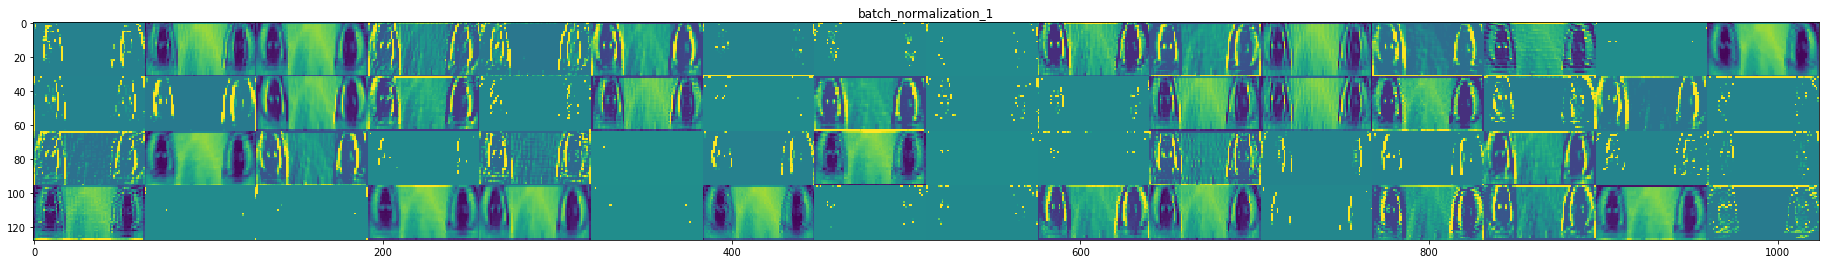

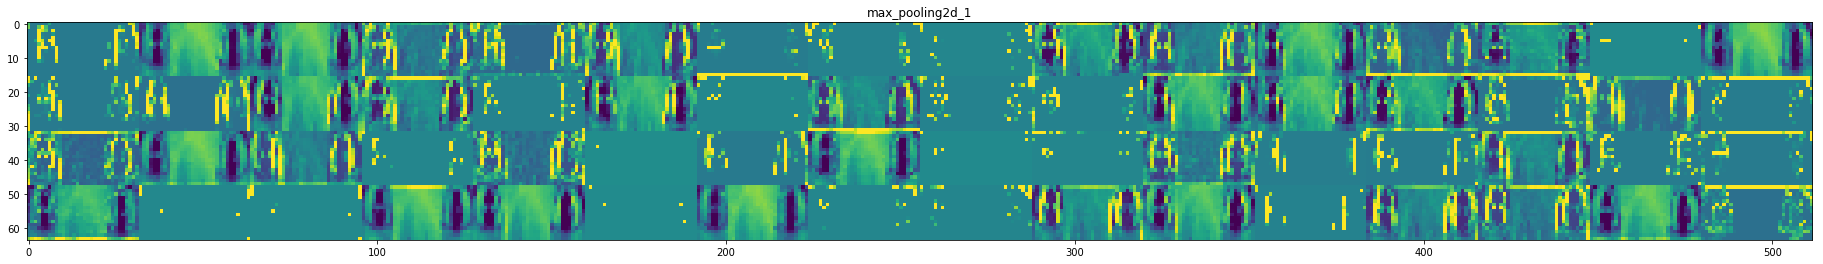

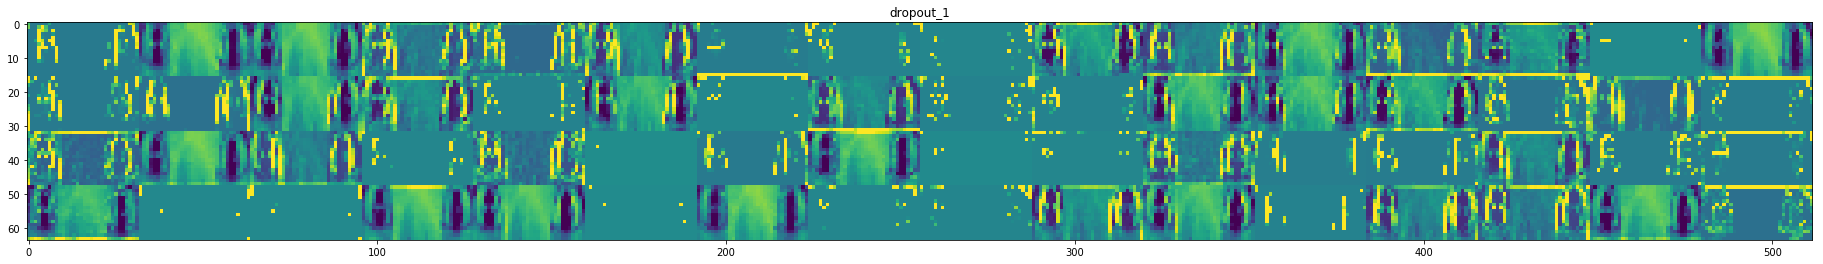

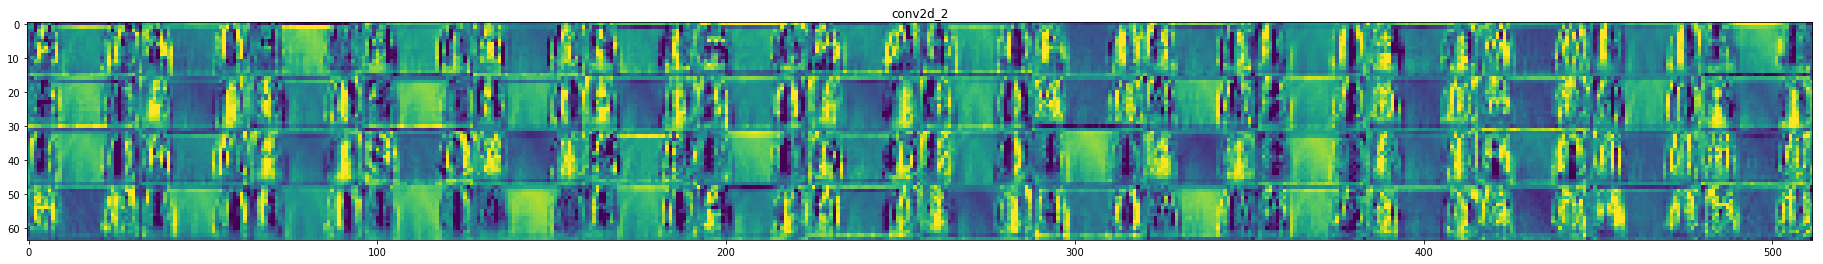

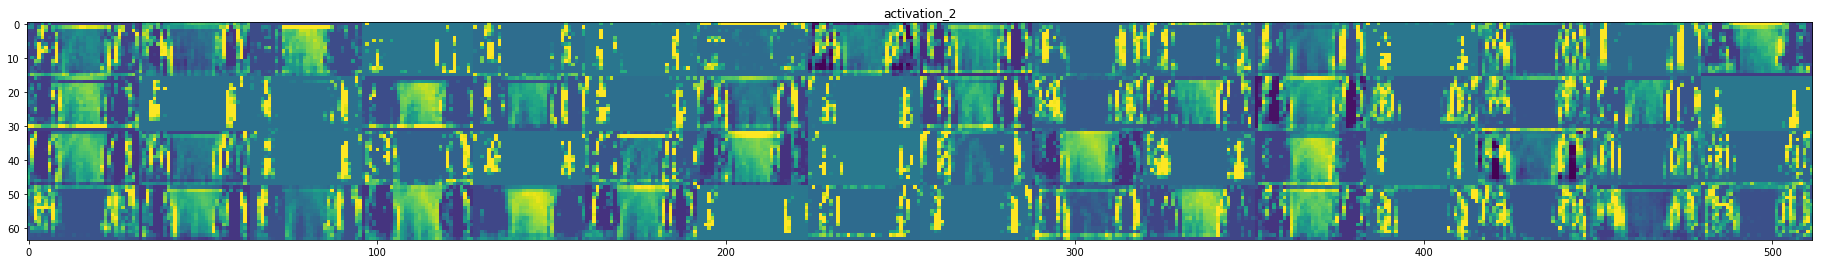

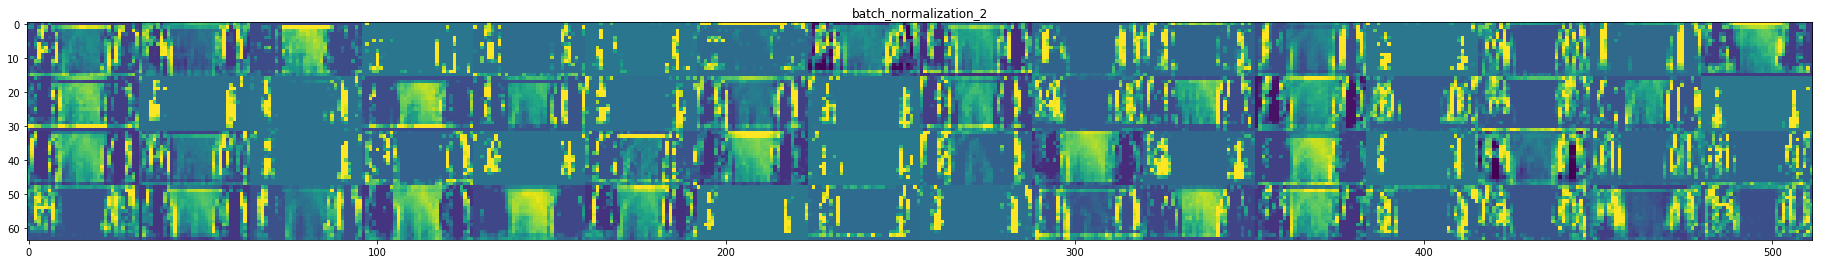

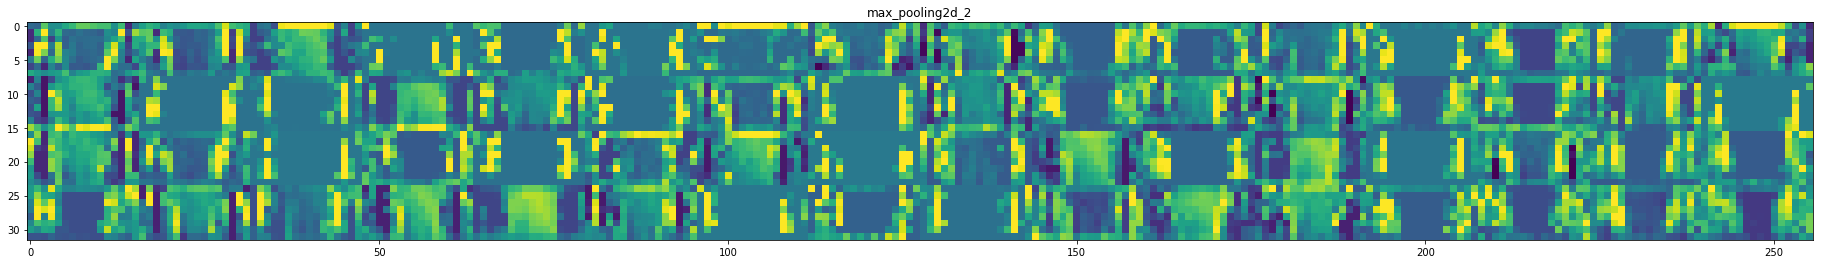

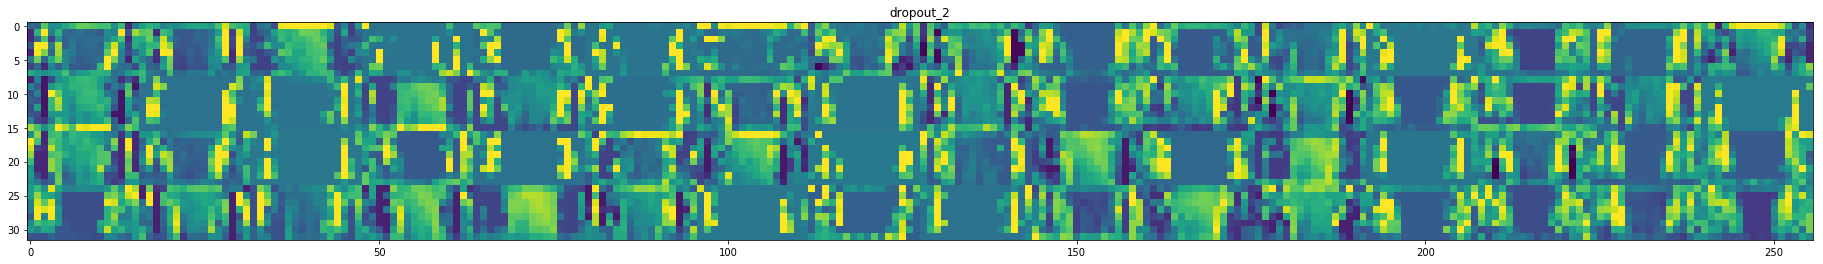

In [34]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    height = layer_activation.shape[1]
    width = layer_activation.shape[2]
    

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((height * n_cols, images_per_row * width))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * height : (col + 1) * height,
                         row * width : (row + 1) * width] = channel_image

    # Display the grid
    scale = 1. / height
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [20]:
# Visualizing convnet filters
layer_name = 'conv2d_2'
filter_index = 63

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [21]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

In [22]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [24]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 32, 64, 1))])

In [25]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 32, 64, 1)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [26]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

In [27]:
def generate_pattern(layer_name, filter_index, height,width):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, height, width, 1)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

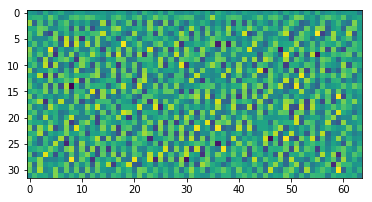

In [28]:
plt.imshow(generate_pattern('conv2d_2', 63, 32,64).squeeze())
plt.show()

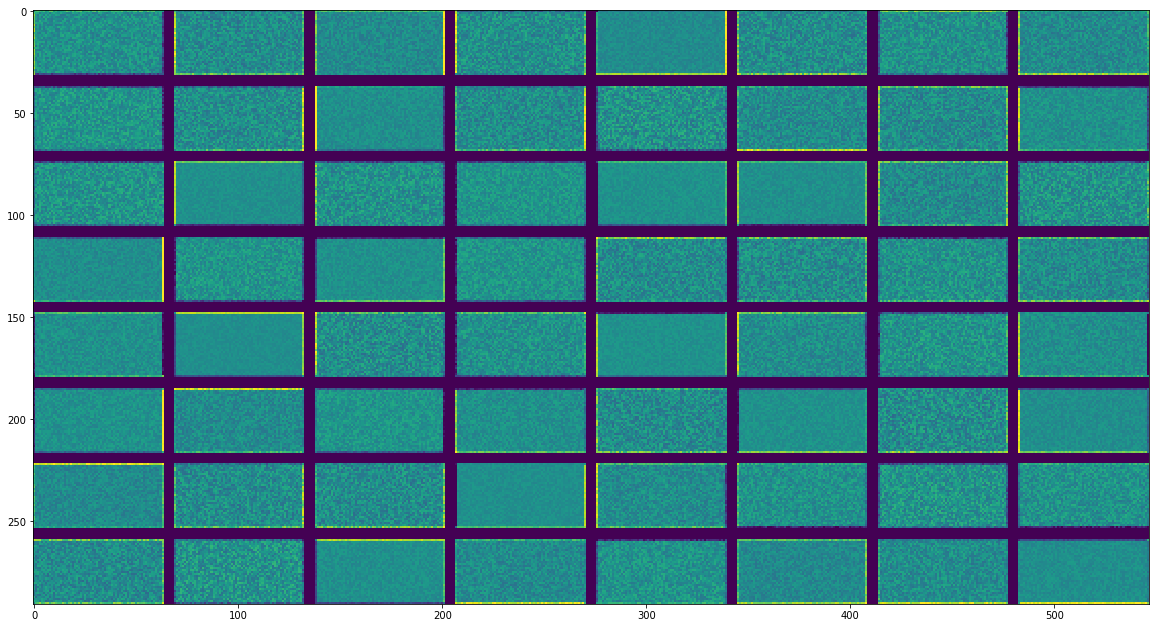

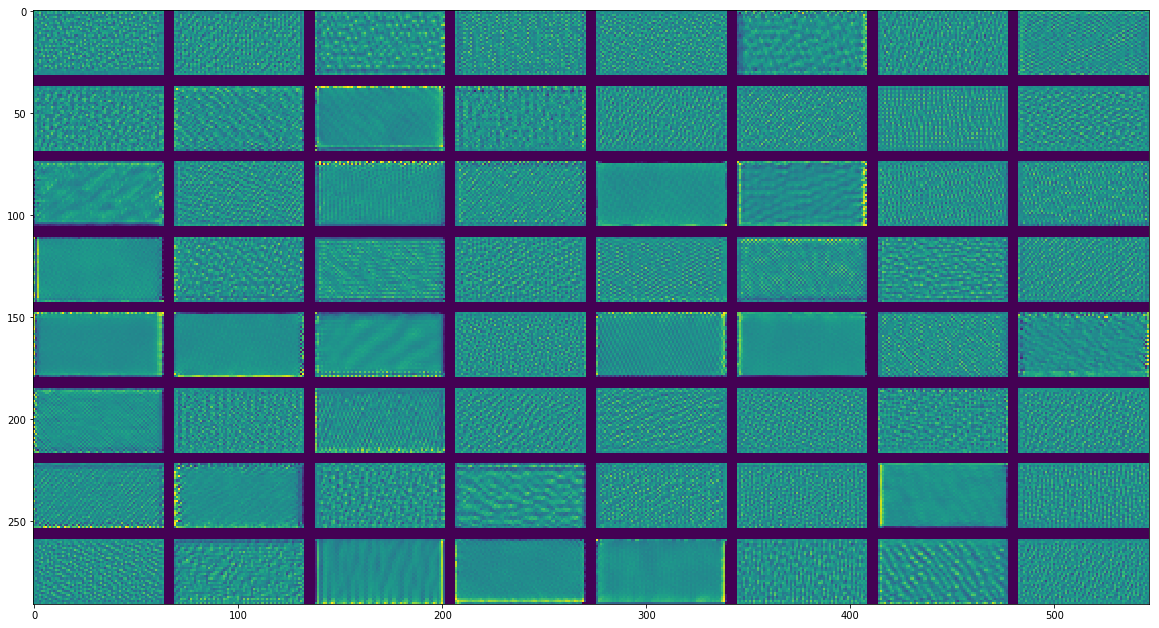

In [33]:
for layer_name in ['conv2d_1','conv2d_2']:
    height = 32
    width = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * 32 + 7 * margin, 8 * 64 + 7 * margin, 1))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), height,width)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * height + i * margin
            horizontal_end = horizontal_start + height
            vertical_start = j * width + j * margin
            vertical_end = vertical_start + width
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.squeeze())
    plt.show()

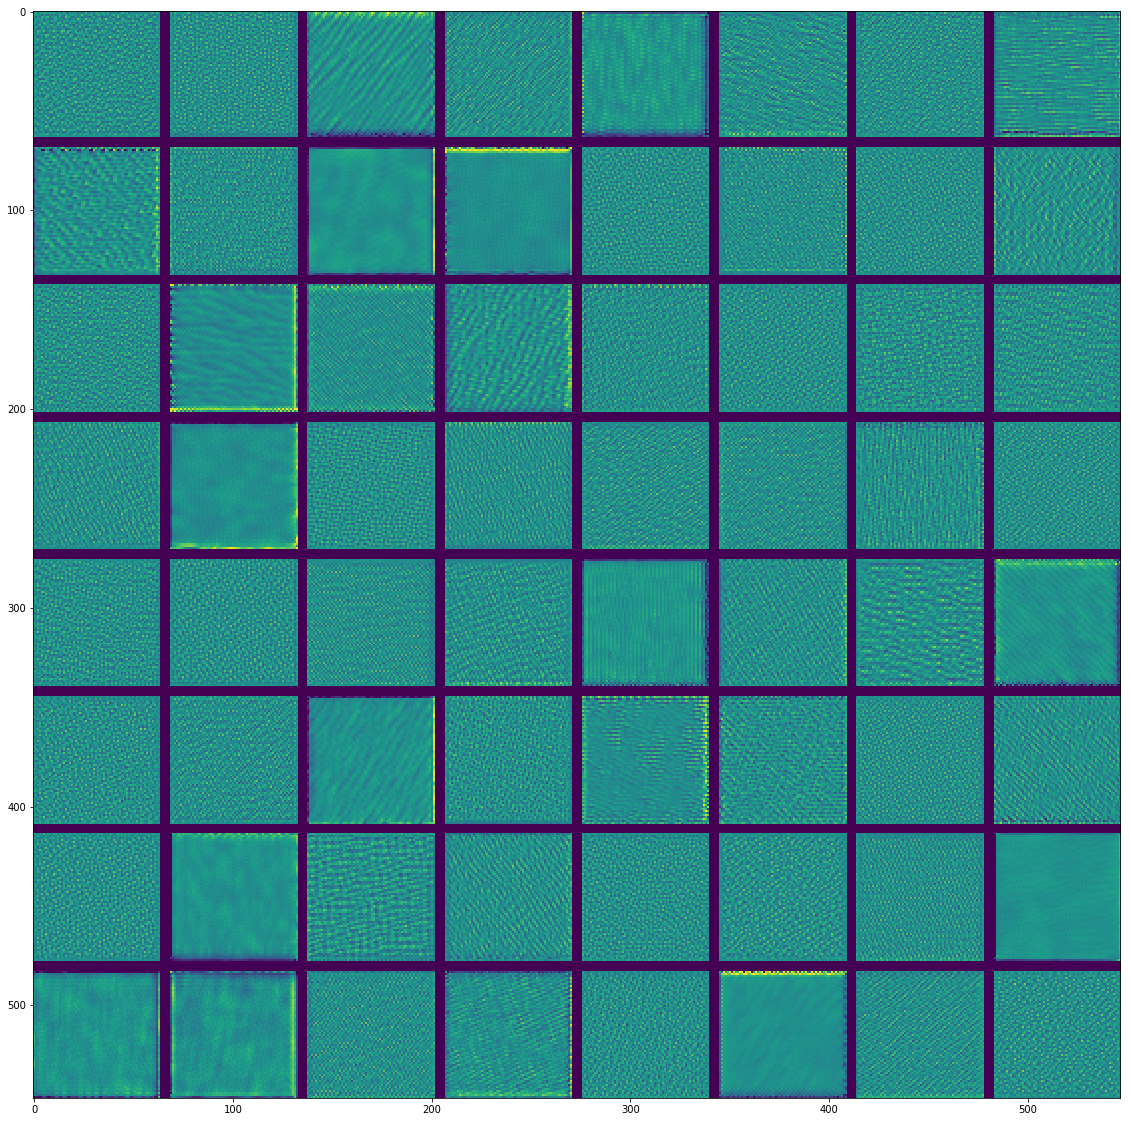

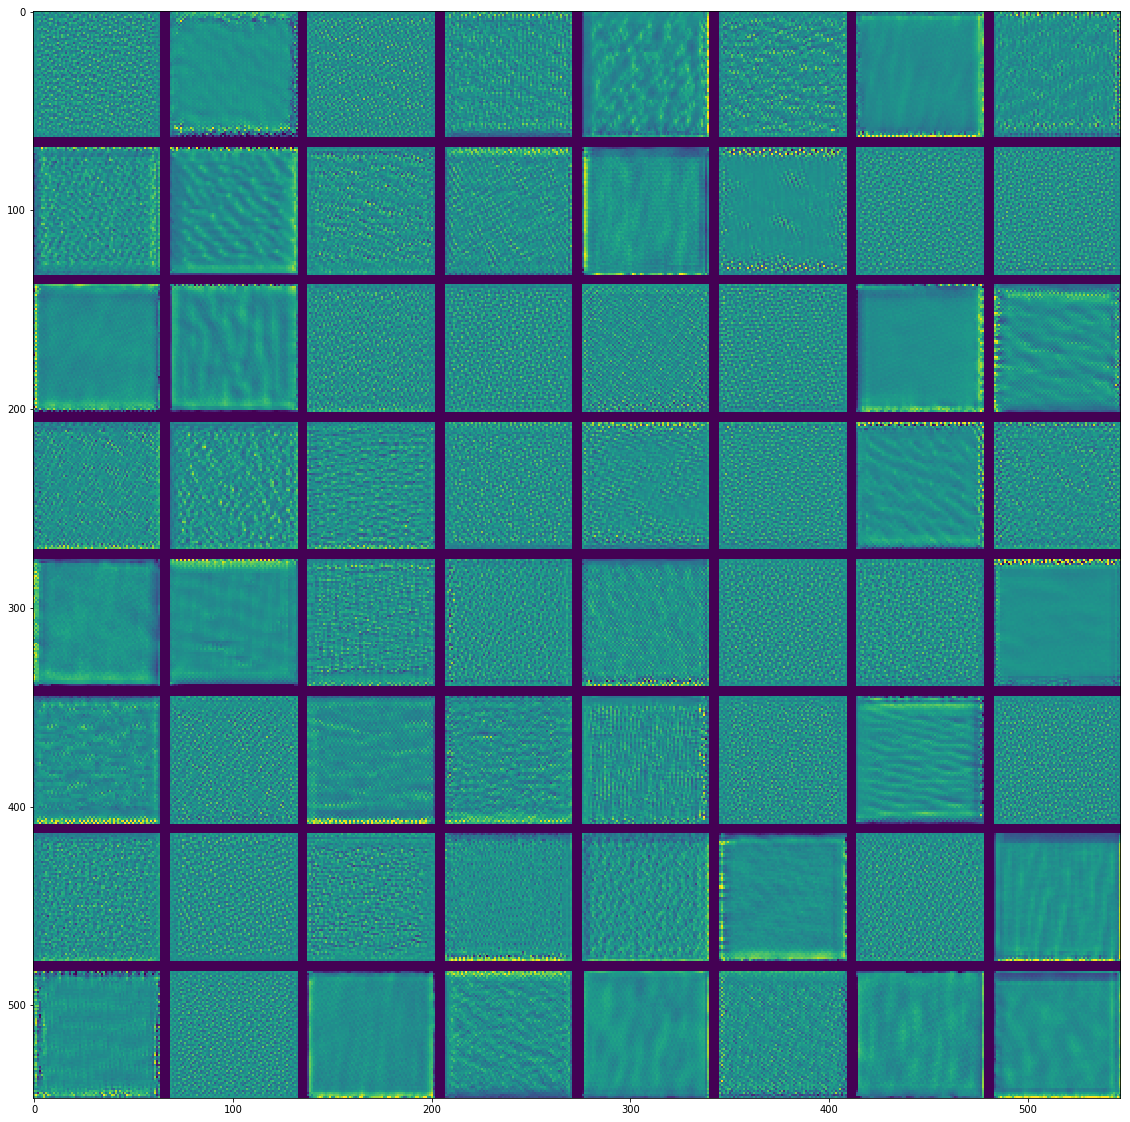

In [87]:
for layer_name in ['conv2d_2', 'conv2d_3']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 1))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.squeeze())
    plt.show()

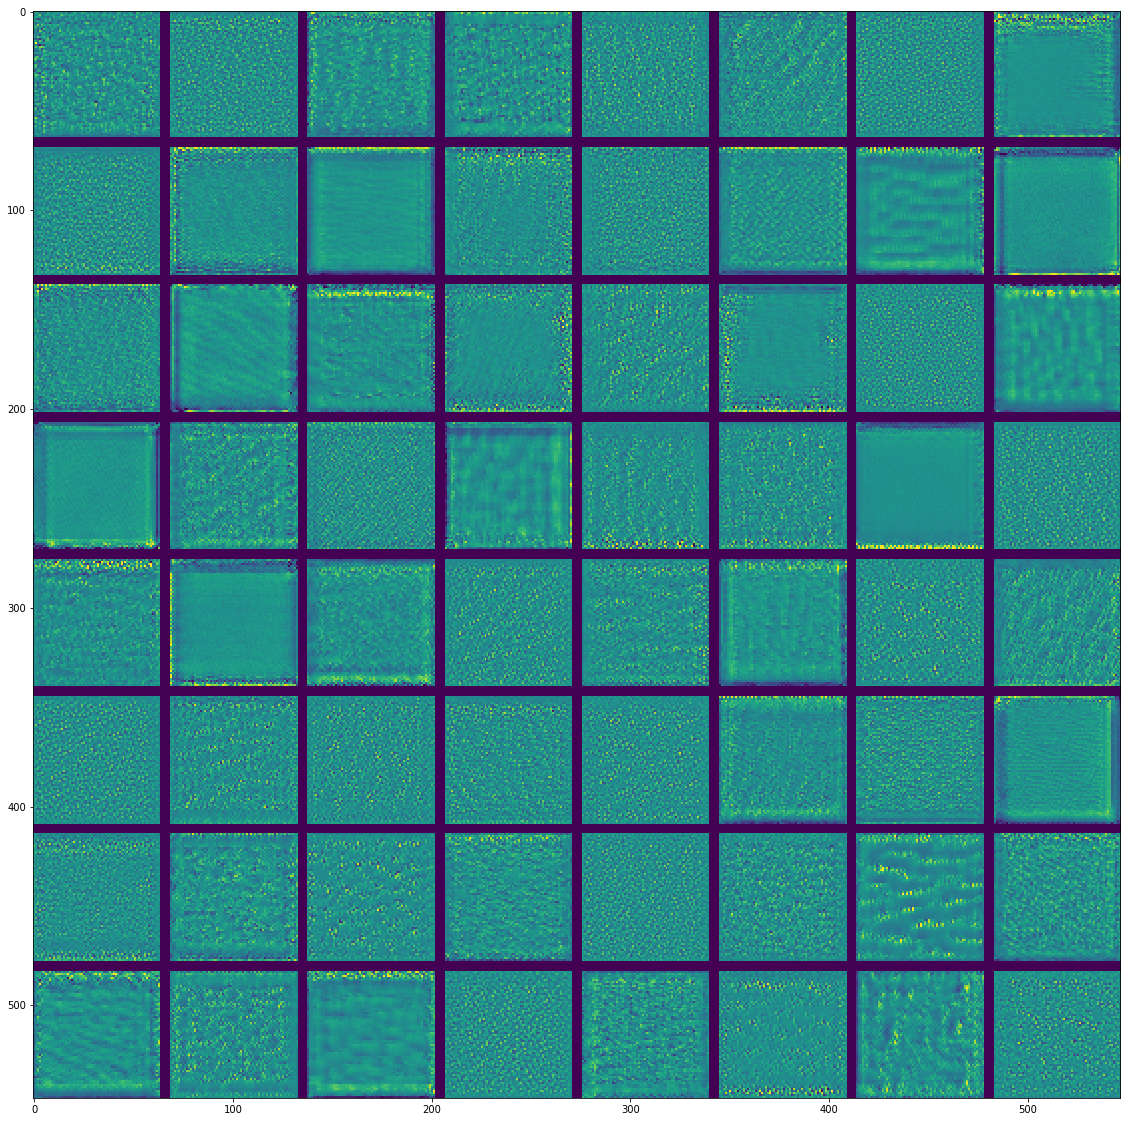

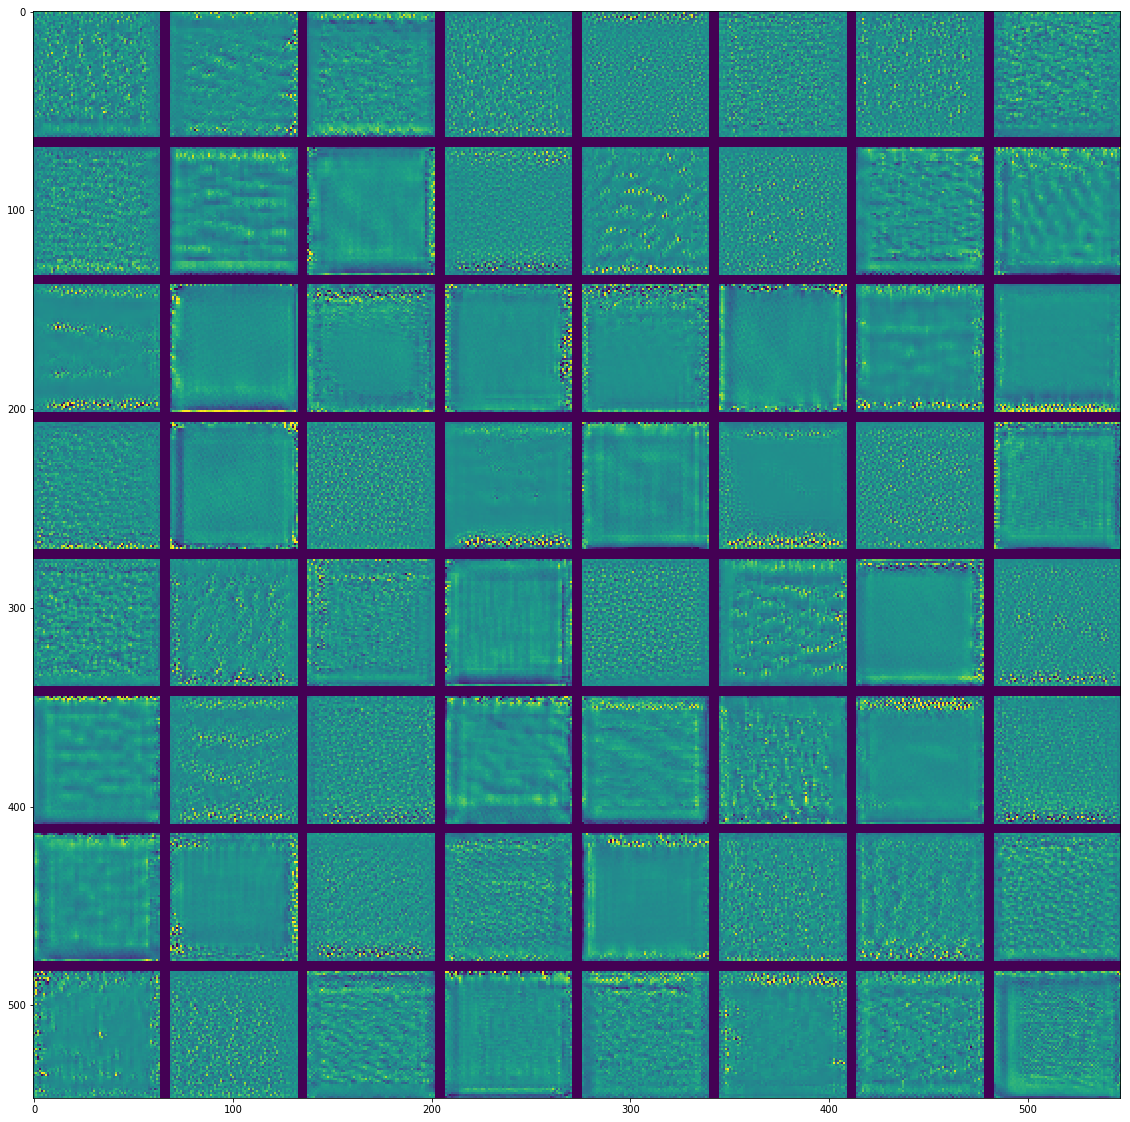

In [113]:
for layer_name in ['conv2d_4', 'conv2d_5']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 1))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.squeeze())
    plt.show()

In [35]:
# heatmap

from keras.applications.vgg16 import preprocess_input, decode_predictions

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)
print(x.shape)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

(1, 32, 64, 1)


IndexError: index 1 is out of bounds for axis 3 with size 1

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])